In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture as GMM
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tuning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tuning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [5]:
df_gmm_clustering = pd.read_csv("data/tuning/clustering/gmm.csv",sep=";")
df_gmm_clustering.head()

K covariance  silhouette  Cal-Harabasz            BIC      DBCV  \
0   7       full    0.013844   2461.600641 -113284.663790 -0.801039   
1   9       full   -0.059354   2339.905689 -113239.922749 -0.799550   
2   8       full   -0.044807   1621.945520 -113237.248176 -0.805253   
3  11       full   -0.045682   1839.374929 -113216.156154 -0.775276   
4  10       full   -0.084101   1814.826214 -113177.498680 -0.765747   

   perplexity wordEmbedding docEmbedding docEmbedding2  
0         NaN          cbow      Moyenne            TF  
1         NaN          cbow      Moyenne            TF  
2         NaN          cbow      Moyenne            TF  
3         NaN          cbow      Moyenne            TF  
4         NaN          cbow      Moyenne            TF

# Avant Tsne

## Moyenne embedding

In [6]:
df_gmm_moy = df_gmm_clustering.loc[(df_gmm_clustering["docEmbedding"] == "Moyenne") & (df_gmm_clustering["perplexity"].isna())].reset_index()

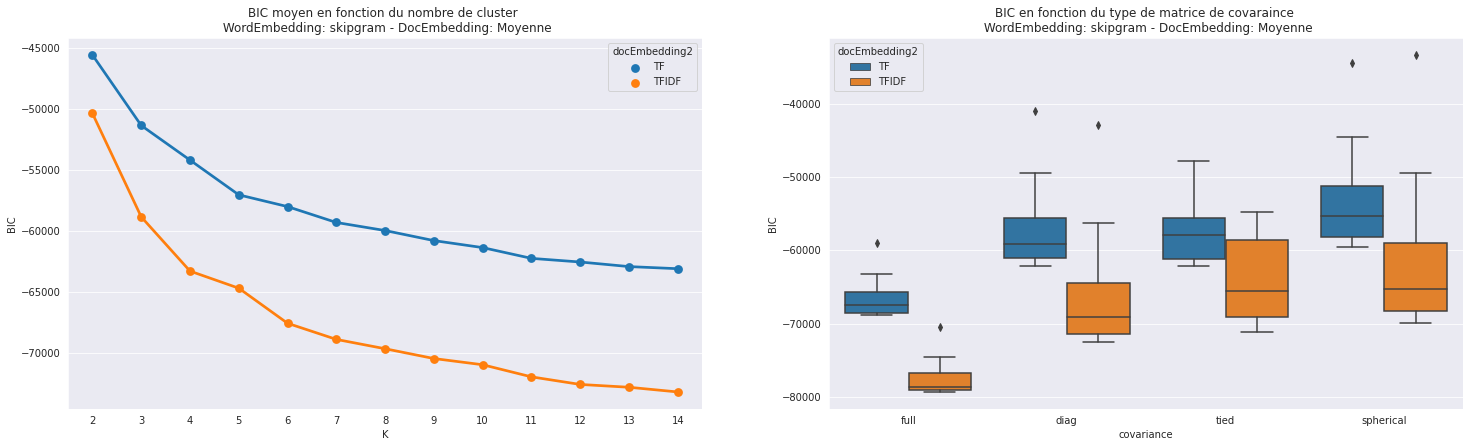

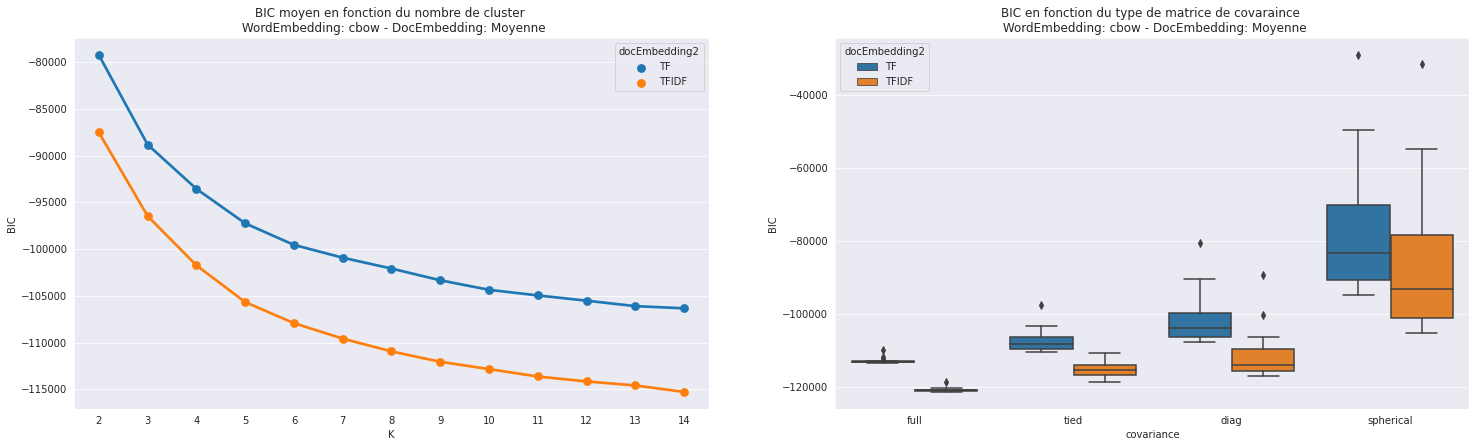

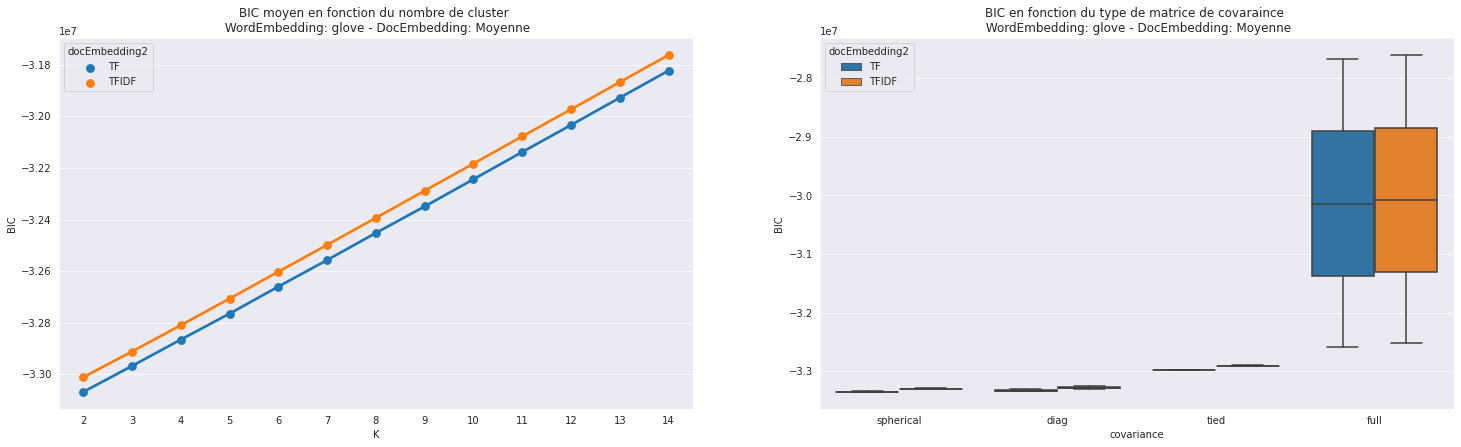

In [7]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ci=None,
        ax=plt.subplot(2,2,1,title=f"BIC moyen en fonction du nombre de cluster \n WordEmbedding: {modele} - DocEmbedding: Moyenne"))
    # sns.boxplot(data = df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="covariance",hue="docEmbedding2",
        ax=plt.subplot(2,2,2,title=f"BIC en fonction du type de matrice de covaraince \n WordEmbedding: {modele} - DocEmbedding: Moyenne"))
    # sns.boxplot(data=df_gmm_moyTF,y="BIC",x="covariance",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="covariance"))
    plt.show()

In [8]:
df_gmm_moy.loc[df_gmm_moy.groupby(["wordEmbedding"])["BIC"].idxmin()]

index   K covariance  silhouette  Cal-Harabasz           BIC      DBCV  \
52     364   7       full    0.059492   3182.479263 -1.212796e+05 -0.738506   
104   1404   5  spherical    0.125838    100.778053 -3.335620e+07 -0.712474   
260   2808  13       full    0.049033   1825.336450 -7.928242e+04 -0.692505   

     perplexity wordEmbedding docEmbedding docEmbedding2  
52          NaN          cbow      Moyenne         TFIDF  
104         NaN         glove      Moyenne            TF  
260         NaN      skipgram      Moyenne         TFIDF

In [9]:
df_gmm_moy.loc[df_gmm_moy.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  K covariance  silhouette  Cal-Harabasz           BIC      DBCV  \
103    415  2  spherical    0.507717  13919.439615 -3.164346e+04 -0.776836   
167   1779  2       diag    0.418284     59.252895 -3.329810e+07 -0.265205   
308   2856  2       tied    0.665797   2705.997782 -5.474153e+04 -0.582056   

     perplexity wordEmbedding docEmbedding docEmbedding2  
103         NaN          cbow      Moyenne         TFIDF  
167         NaN         glove      Moyenne         TFIDF  
308         NaN      skipgram      Moyenne         TFIDF

## WMD

In [10]:
df_gmm_wmd = df_gmm_clustering.loc[(df_gmm_clustering["docEmbedding"] == "WMD") & (df_gmm_clustering["perplexity"].isna())].reset_index()

<AxesSubplot:title={'center':'WMD MDS'}, xlabel='covariance', ylabel='BIC'>

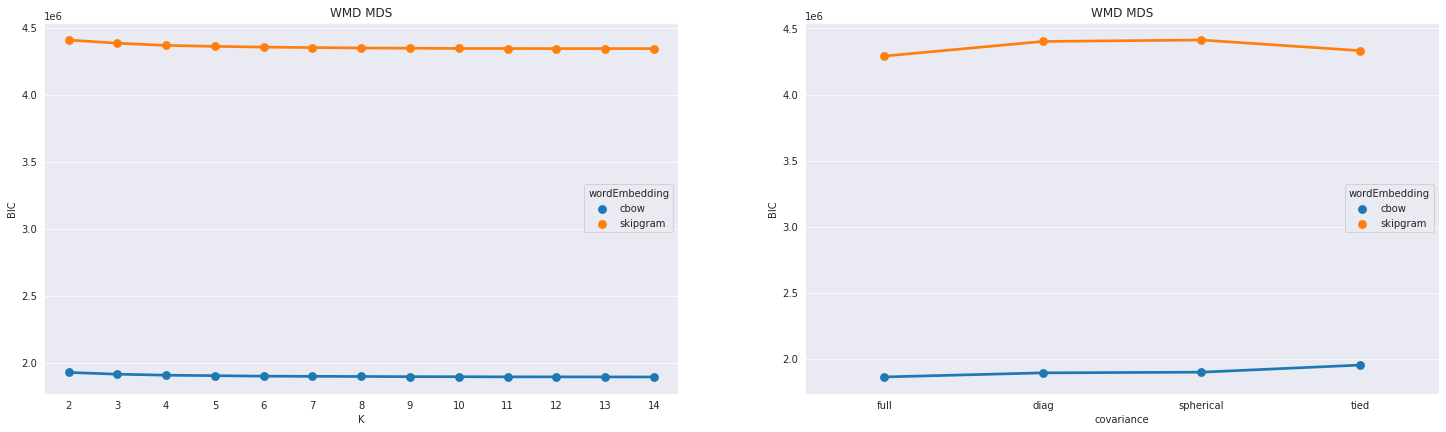

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
df_gmm_wmdMDS = df_gmm_wmd[df_gmm_wmd["docEmbedding2"]=="MDS"]

sns.pointplot(data=df_gmm_wmdMDS,y="BIC",x="K",hue="wordEmbedding",ci=None, ax=plt.subplot(2,2,1,title="WMD MDS"))
# sns.boxplot(data = df_gmm_moyTF,y="BIC",x="K",hue="wordEmbedding",ax=plt.subplot(2,2,1,title="K"))

sns.pointplot(data=df_gmm_wmdMDS,y="BIC",x="covariance",hue="wordEmbedding",ci=None, ax=plt.subplot(2,2,2,title="WMD MDS"))
# sns.boxplot(data=df_gmm_moyTF,y="BIC",x="covariance",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="covariance"))

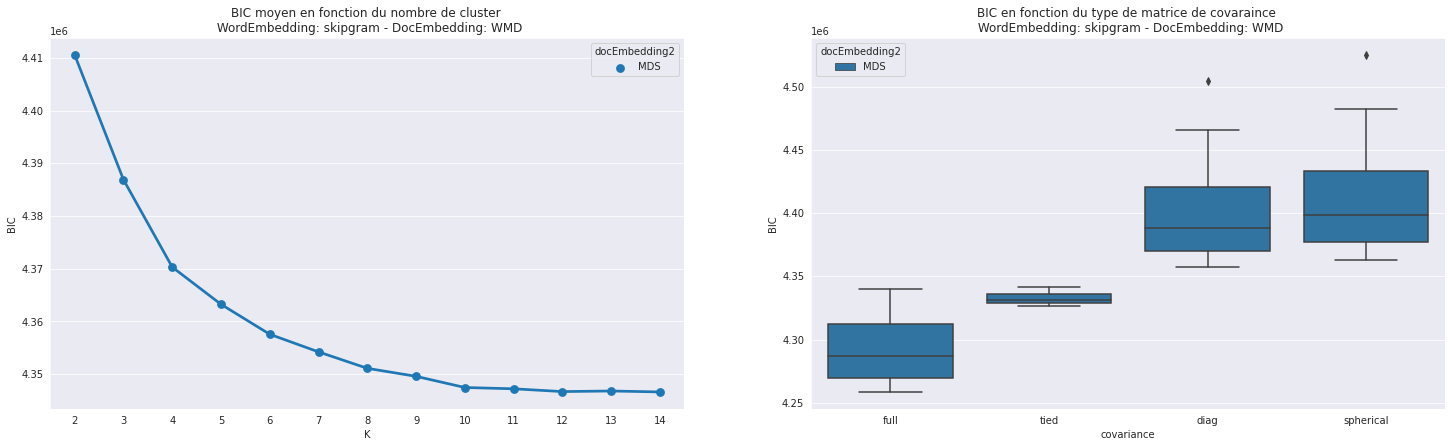

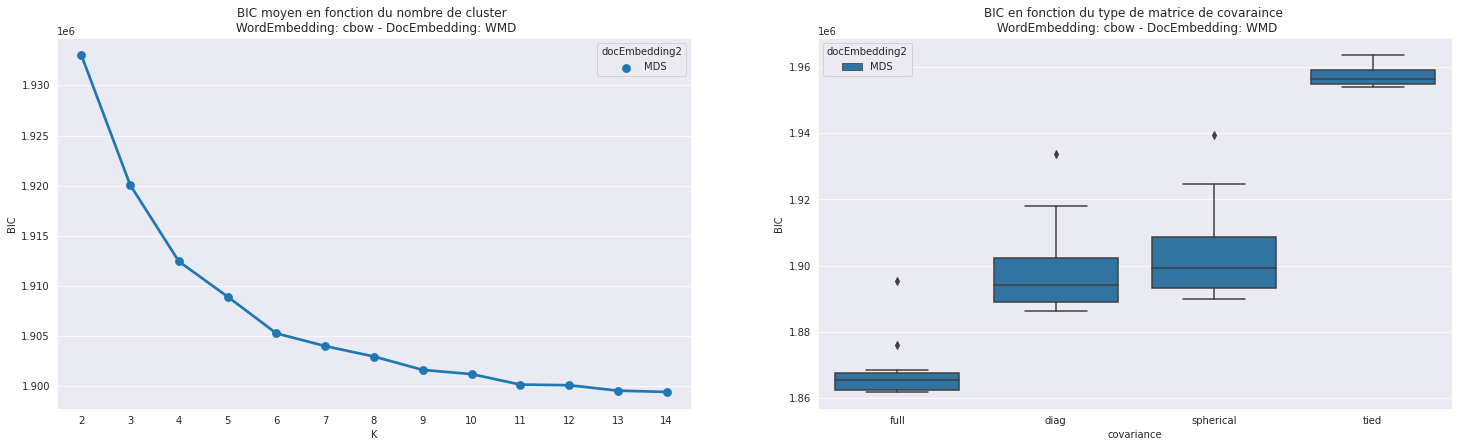

In [12]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_gmm_wmd[df_gmm_wmd["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ci=None,
        ax=plt.subplot(2,2,1,title=f"BIC moyen en fonction du nombre de cluster \n WordEmbedding: {modele} - DocEmbedding: WMD"))
    # sns.boxplot(data = df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_gmm_wmd[df_gmm_wmd["wordEmbedding"]==modele],y="BIC",x="covariance",hue="docEmbedding2",
        ax=plt.subplot(2,2,2,title=f"BIC en fonction du type de matrice de covaraince \n WordEmbedding: {modele} - DocEmbedding: WMD"))
    # sns.boxplot(data=df_gmm_moyTF,y="BIC",x="covariance",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="covariance"))
    plt.show()

In [13]:
df_gmm_wmd.loc[df_gmm_wmd.groupby("wordEmbedding")["BIC"].idxmin()]

index  K covariance  silhouette  Cal-Harabasz           BIC      DBCV  \
0     728  8       full   -0.110894    269.982137  1.861913e+06 -0.490757   
52   3172  3       full   -0.006289    239.813633  4.258660e+06 -0.417439   

    perplexity wordEmbedding docEmbedding docEmbedding2  
0          NaN          cbow          WMD           MDS  
52         NaN      skipgram          WMD           MDS

In [14]:
df_gmm_wmd.loc[df_gmm_wmd.groupby(["wordEmbedding","docEmbedding2"])["silhouette"].idxmax()]

index  K covariance  silhouette  Cal-Harabasz           BIC      DBCV  \
51    779  2       tied    0.309662    978.347415  1.963595e+06 -0.626110   
77   3197  2       tied    0.383654   2147.307636  4.341957e+06 -0.667619   

    perplexity wordEmbedding docEmbedding docEmbedding2  
51         NaN          cbow          WMD           MDS  
77         NaN      skipgram          WMD           MDS

# Avec TSNE

## Moyenne

In [15]:
df_gmm_moy2 = df_gmm_clustering.loc[(df_gmm_clustering["docEmbedding"] == "Moyenne") & (df_gmm_clustering["perplexity"].notna())].reset_index()

In [16]:
df_gmm_moy2.loc[df_gmm_moy2.groupby(["wordEmbedding","docEmbedding"])["silhouette"].idxmax()]

index  K covariance  silhouette  Cal-Harabasz            BIC      DBCV  \
610     714  3       full    0.514020  14089.783315  154273.015316 -0.632999   
723    1555  3  spherical    0.382828   7531.152914  174574.614217 -0.874039   
1870   3170  2       diag    0.493039  12947.772932  161156.436097 -0.577367   

      perplexity wordEmbedding docEmbedding docEmbedding2  
610        200.0          cbow      Moyenne         TFIDF  
723         75.0         glove      Moyenne            TF  
1870       200.0      skipgram      Moyenne         TFIDF

In [17]:
df_gmm_moy2.loc[df_gmm_moy2.groupby(["wordEmbedding","docEmbedding"])["BIC"].idxmin()]

index   K covariance  silhouette  Cal-Harabasz            BIC      DBCV  \
572     676  14       full    0.374882  20402.724174  148203.399000 -0.597088   
1196   2080  10       full    0.306611   5381.949530   94941.986936 -0.657510   
1508   2756  14       full    0.351409  10551.681468  154306.688471 -0.549786   

      perplexity wordEmbedding docEmbedding docEmbedding2  
572        200.0          cbow      Moyenne         TFIDF  
1196       200.0         glove      Moyenne         TFIDF  
1508       200.0      skipgram      Moyenne            TF

## WMD

In [18]:
df_gmm_wmd2 = df_gmm_clustering.loc[(df_gmm_clustering["docEmbedding"] == "WMD") & (df_gmm_clustering["perplexity"].notna())].reset_index()

In [19]:
df_gmm_wmd2.loc[df_gmm_wmd2.groupby(["wordEmbedding","docEmbedding"])["silhouette"].idxmax()]

index  K covariance  silhouette  Cal-Harabasz            BIC      DBCV  \
411    1191  3  spherical    0.418433   8923.536970  180179.763974 -0.877154   
926    2434  3       full    0.394457   8030.912467  158977.981824 -0.831220   
1195   3483  2  spherical    0.467767  12258.367026  146958.796874 -0.805287   

      perplexity wordEmbedding docEmbedding docEmbedding2  
411         75.0          cbow          WMD      Distance  
926        200.0         glove          WMD      Distance  
1195       150.0      skipgram          WMD           MDS

In [20]:
df_gmm_wmd2.loc[df_gmm_wmd2.groupby(["wordEmbedding","docEmbedding"])["BIC"].idxmin()]

index   K covariance  silhouette  Cal-Harabasz            BIC      DBCV  \
260    1040  14       full    0.354321   8963.111538  135141.256199 -0.642460   
884    2392  13       diag    0.343957   8312.567488  157728.849426 -0.781775   
1196   3484  14       full    0.356543  10424.176266  134189.267290 -0.638906   

      perplexity wordEmbedding docEmbedding docEmbedding2  
260        200.0          cbow          WMD           MDS  
884        200.0         glove          WMD      Distance  
1196       200.0      skipgram          WMD           MDS

# Plot ScatterPlot

In [21]:
def plot_gmm(df_gmm,dict_embedding,gmm_metric="BIC",first_reduce=False,modele="cbow"):
    best_model = df_gmm.loc[df_gmm.groupby(["wordEmbedding"])[gmm_metric].idxmin()] if gmm_metric == "BIC" else df_gmm.loc[df_gmm.groupby(["wordEmbedding"])[gmm_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"


        doc_embedding = dict_embedding[modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)

        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])
        gmm_model = GMM(n_components=best_model["K"].values[0],covariance_type=best_model["covariance"].values[0])
        gmm_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]
        labels = gmm_model.fit_predict(gmm_data)

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]

        title = f"Best {best_model['docEmbedding'].values[0]} DocEmbedding GMM Clustering based on {gmm_metric}"
        subtitle1 = f"WordEmbedding: {modele} - DocEmbedding: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - Reduced Before Clustering: {first_reduce}"
        subtitle2 = f"Number of cluster: {len(np.unique(labels))} - BIC: {round(best_model['BIC'].values[0])} - Silhouette: {round(best_model['silhouette'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

## Moyenne Embedding

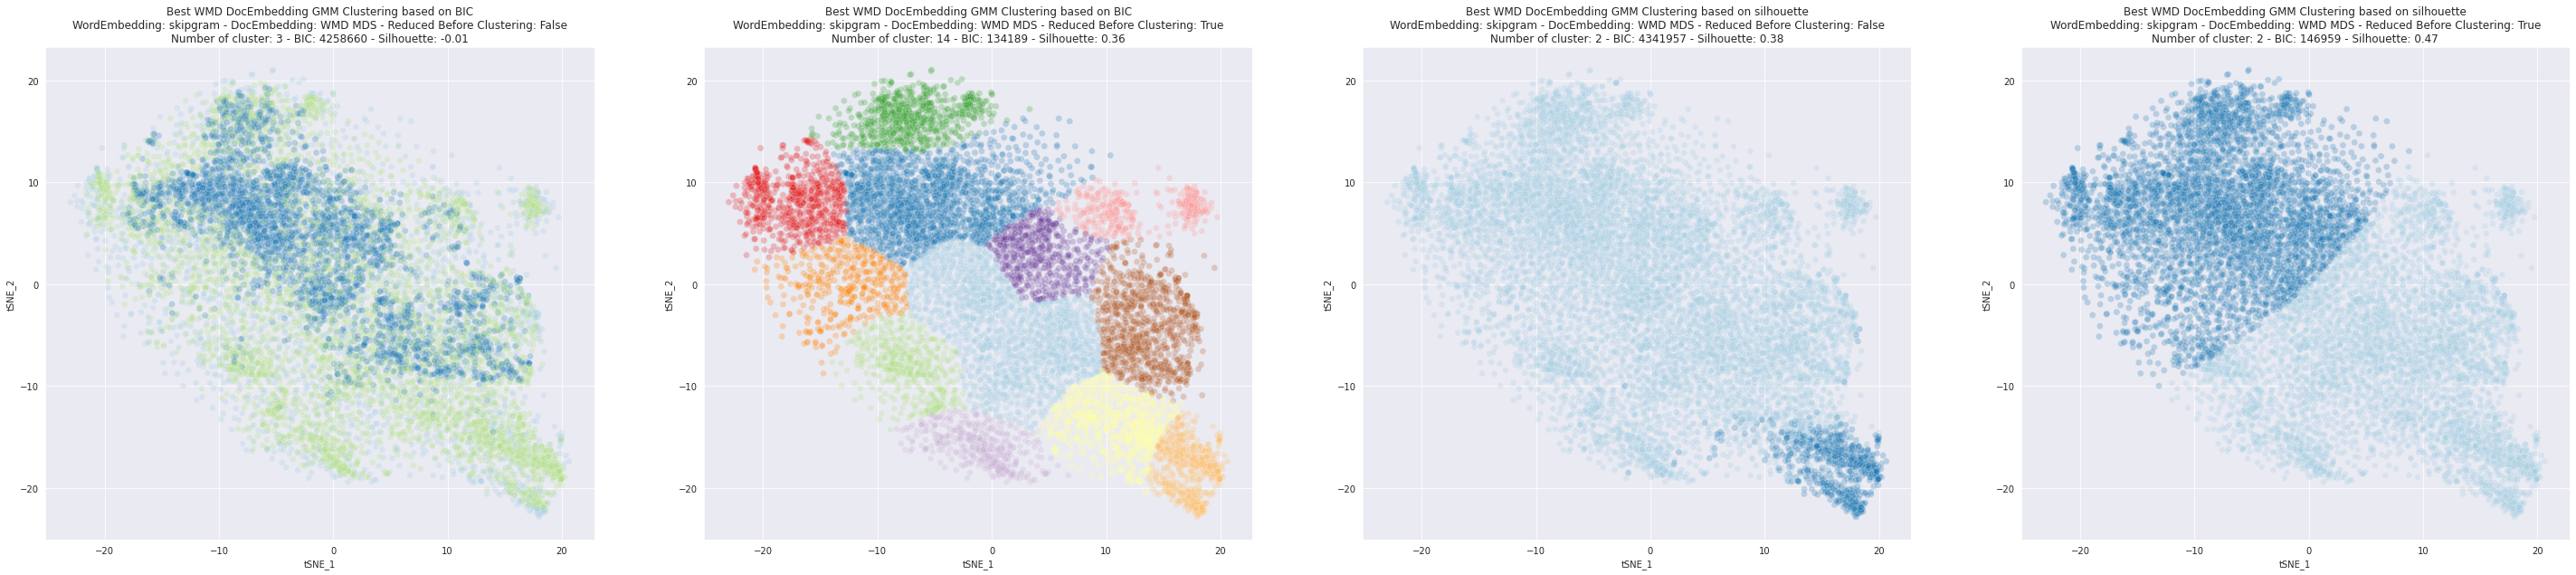

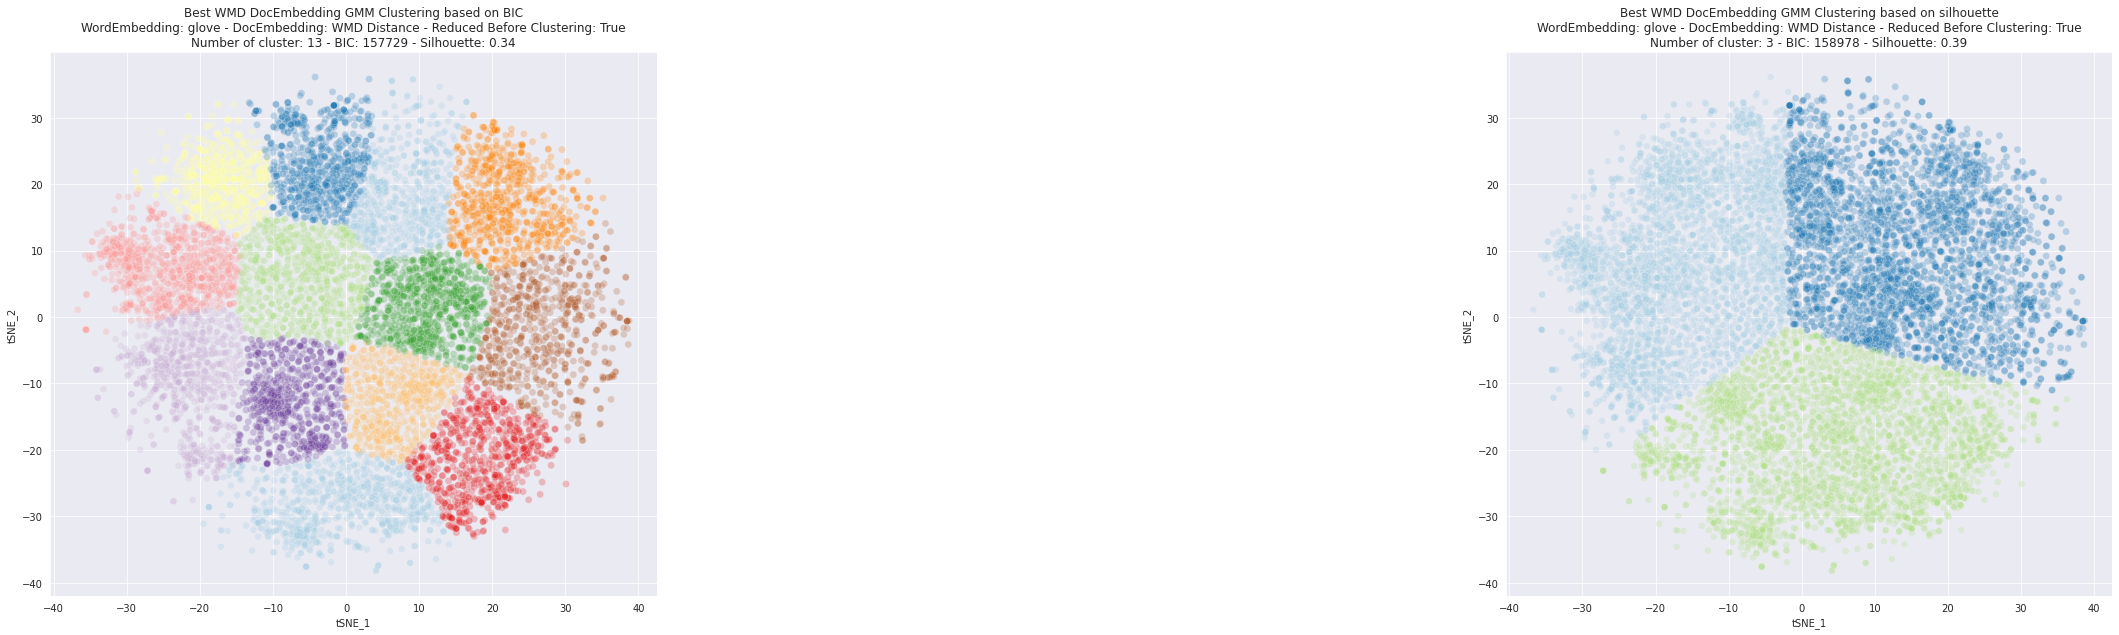

KeyboardInterrupt: 

In [22]:
for modele in ["skipgram","glove","cbow"]:
    # BIC
    labels_bic, tsne_wmd_bic, bic_colors, bic_title = plot_gmm(df_gmm_wmd,dict_wmd_embedding,gmm_metric="BIC",first_reduce=False,modele=modele)
    labels_bic2, tsne_wmd_bic2, bic_colors2, bic_title2 = plot_gmm(df_gmm_wmd2,dict_wmd_embedding,gmm_metric="BIC",first_reduce=True,modele=modele)
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_gmm(df_gmm_wmd,dict_wmd_embedding,gmm_metric="silhouette",first_reduce=False,modele=modele)
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_gmm(df_gmm_wmd2,dict_wmd_embedding,gmm_metric="silhouette",first_reduce=True,modele=modele)

    #Plot
    plt.figure(figsize = (50,10))
    if bic_title is not None:
        sns.scatterplot(tsne_wmd_bic[:,0],tsne_wmd_bic[:,1], s=50, c=bic_colors, alpha=0.25,ax=plt.subplot(1,4,1,title=bic_title))
        plt.xlabel("tSNE_1")
        plt.ylabel("tSNE_2")
    sns.scatterplot(tsne_wmd_bic2[:,0],tsne_wmd_bic2[:,1], s=50, c=bic_colors2, alpha=0.25,ax=plt.subplot(1,4,2,title=bic_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")
    
    if silhouette_title is not None:
        sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,4,3,title=silhouette_title))
        plt.xlabel("tSNE_1")
        plt.ylabel("tSNE_2")
    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(1,4,4,title=silhouette_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")
    
    plt.show()

## Moyenne Embedding

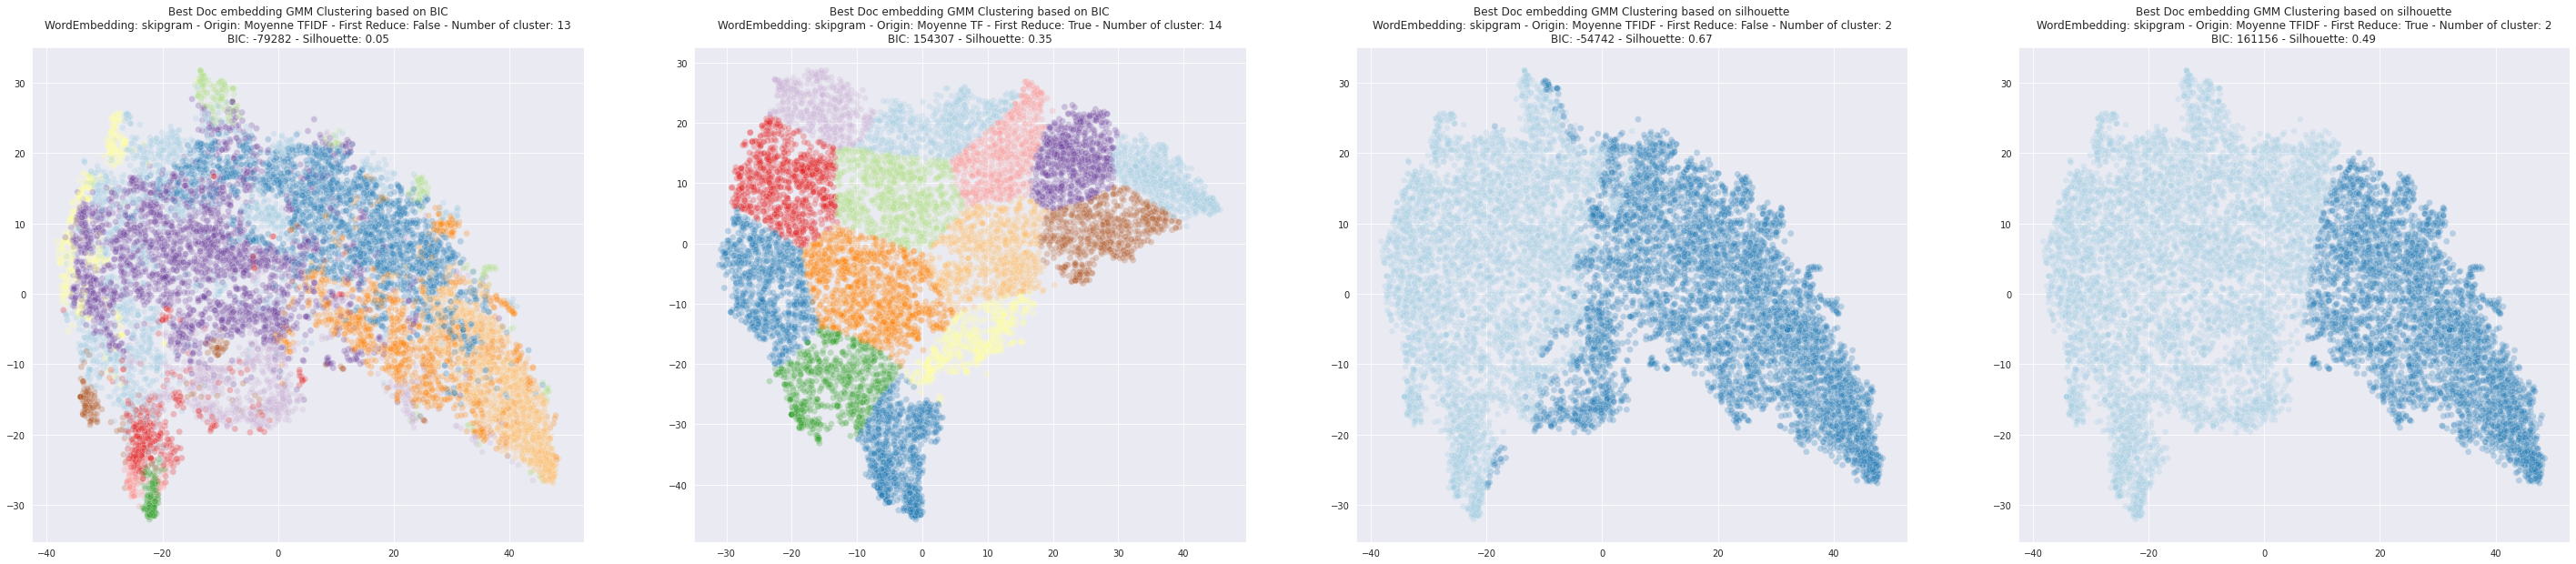

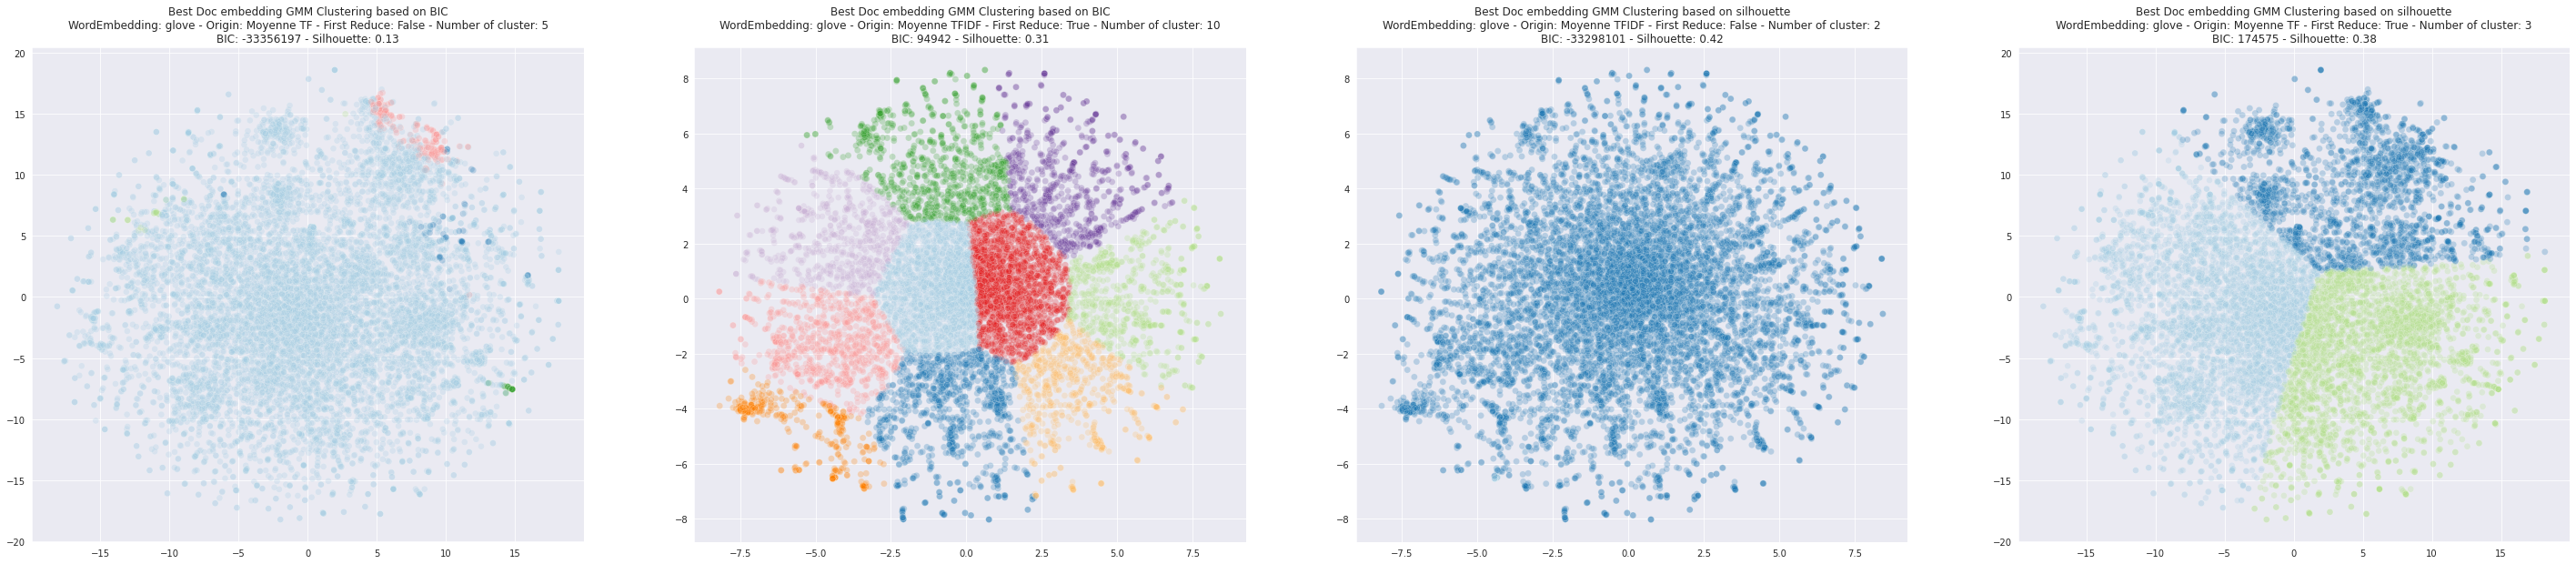

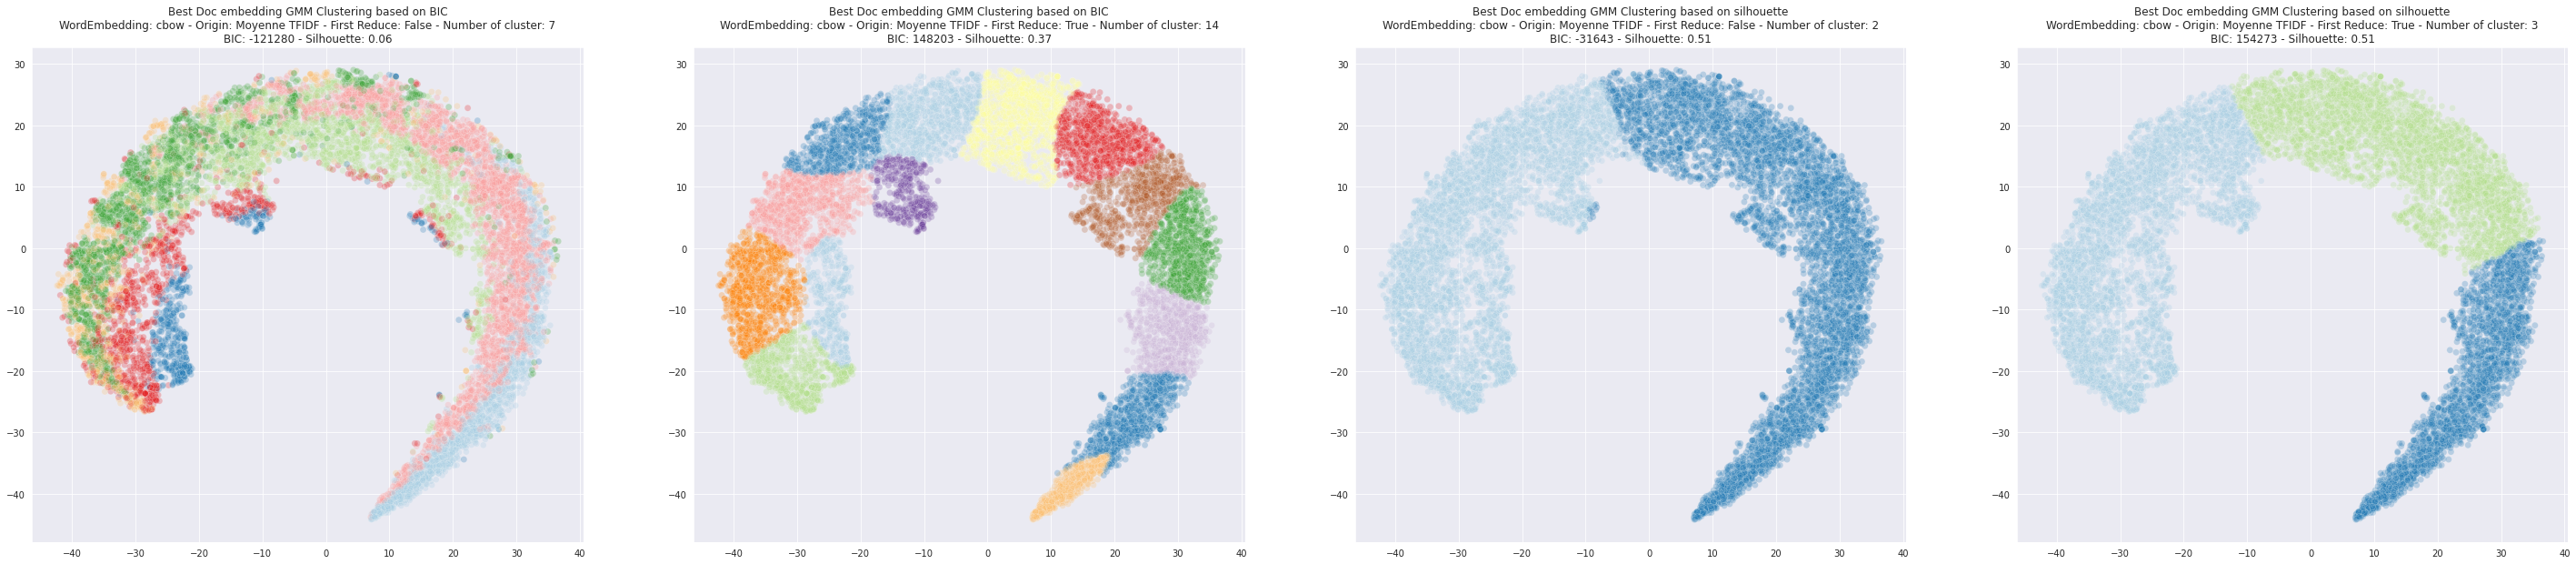

In [ ]:
for modele in ["skipgram","glove","cbow"]:
    # BIC
    labels_bic, tsne_wmd_bic, bic_colors, bic_title = plot_gmm(df_gmm_moy,dict_moy_embedding,gmm_metric="BIC",first_reduce=False,modele=modele)
    labels_bic2, tsne_wmd_bic2, bic_colors2, bic_title2 = plot_gmm(df_gmm_moy2,dict_moy_embedding,gmm_metric="BIC",first_reduce=True,modele=modele)
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_gmm(df_gmm_moy,dict_moy_embedding,gmm_metric="silhouette",first_reduce=False,modele=modele)
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_gmm(df_gmm_moy2,dict_moy_embedding,gmm_metric="silhouette",first_reduce=True,modele=modele)

    #Plot
    plt.figure(figsize = (50,10))
    if bic_title is not None:
        sns.scatterplot(tsne_wmd_bic[:,0],tsne_wmd_bic[:,1], s=50, c=bic_colors, alpha=0.25,ax=plt.subplot(1,4,1,title=bic_title))
        plt.xlabel("tSNE_1")
        plt.ylabel("tSNE_2")
    sns.scatterplot(tsne_wmd_bic2[:,0],tsne_wmd_bic2[:,1], s=50, c=bic_colors2, alpha=0.25,ax=plt.subplot(1,4,2,title=bic_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")
    
    if silhouette_title is not None:
        sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,4,3,title=silhouette_title))
        plt.xlabel("tSNE_1")
        plt.ylabel("tSNE_2")
    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(1,4,4,title=silhouette_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")
    plt.show()